# Customer Segmentation Prediction for New Markets

## Context
An automobile company plans to enter new markets with existing products (P1-P5). Based on market research, the new market behavior is similar to their existing market. In the existing market, customers are classified into 4 segments (A, B, C, D), and this segmented outreach strategy has been highly successful. The goal is to predict the correct segment for 2627 new potential customers.

## Goal
Develop a machine learning model to predict the customer segment (A, B, C, or D).

## Phase 1: Setup and Data Loading

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

#  Model Imports 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Set up environment for better visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Define file paths
TRAIN_FILE = "Train.csv"
TEST_FILE = "Test.csv"


In [4]:
# Load the datasets
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)
print("Data loaded successfully.")

# Rename the target column for clarity
df_train.rename(columns={'Segmentation': 'Segment'}, inplace=True)

# Store the Test IDs for submission
test_ids = df_test['ID']

# Display initial information
print("\n--- Training Data Info ---")
df_train.info()
print("\n--- Test Data Info ---")
df_test.info()

# Display the first few rows of the training data
print("\n--- Training Data Head ---")
print(df_train.head())

# Check the target variable distribution
print("\n--- Target Variable Distribution (Segment) ---")
print(df_train['Segment'].value_counts(normalize=True) * 100)

Data loaded successfully.

--- Training Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segment          8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB

--- Test Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  


### 2.1 Data Cleaning and Missing Values

In [5]:
# Function to check for missing values
def check_missing_values(df, name):
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    missing_percent = (missing / len(df)) * 100
    missing_data = pd.DataFrame({'Missing Count': missing, 'Missing Percent': missing_percent})
    print(f"\n--- Missing Values in {name} Data ---")
    print(missing_data.sort_values(by='Missing Percent', ascending=False))
    return missing_data

check_missing_values(df_train, "Train")
check_missing_values(df_test, "Test")


--- Missing Values in Train Data ---
                 Missing Count  Missing Percent
Work_Experience            829        10.275161
Family_Size                335         4.152206
Ever_Married               140         1.735250
Profession                 124         1.536936
Graduated                   78         0.966782
Var_1                       76         0.941993

--- Missing Values in Test Data ---
                 Missing Count  Missing Percent
Work_Experience            269        10.239817
Family_Size                113         4.301485
Ever_Married                50         1.903312
Profession                  38         1.446517
Var_1                       32         1.218120
Graduated                   24         0.913590


,Missing Count,Missing Percent
Ever_Married,50,1.903312
Graduated,24,0.913590
Profession,38,1.446517
Work_Experience,269,10.239817
Family_Size,113,4.301485
Var_1,32,1.218120


### 2.2 Exploratory Data Analysis (EDA) - Visualizations

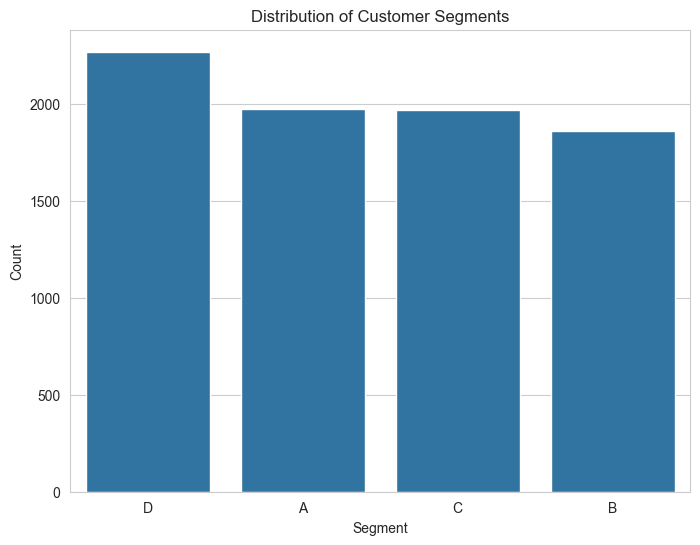

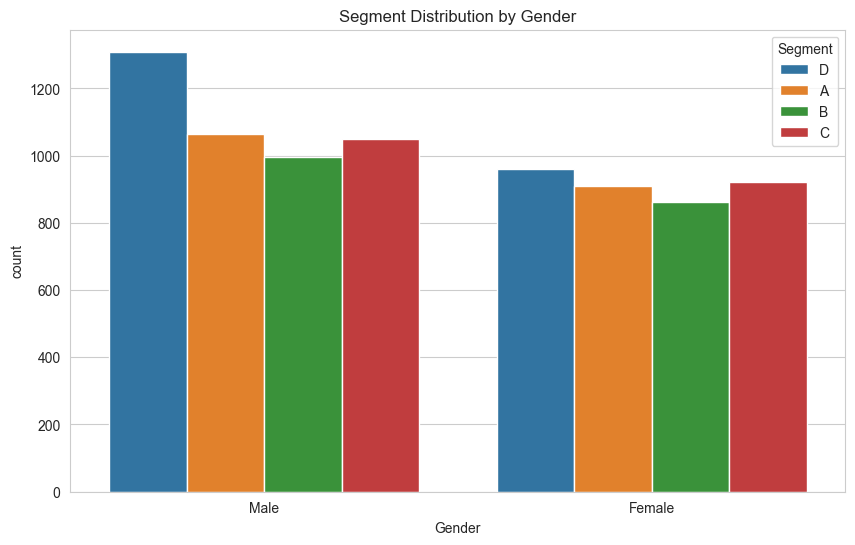

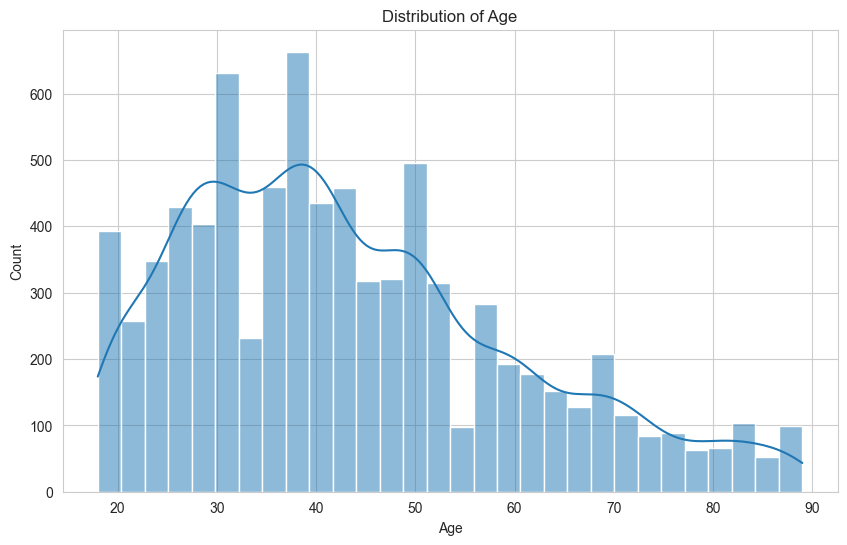

In [6]:
# Visualize the distribution of the target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Segment', data=df_train, order=df_train['Segment'].value_counts().index)
plt.title('Distribution of Customer Segments')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.show()

# Visualize the relationship between 'Gender' and 'Segment'
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='Segment', data=df_train)
plt.title('Segment Distribution by Gender')
plt.show()

# Visualize the distribution of 'Age'
plt.figure(figsize=(10, 6))
sns.histplot(df_train['Age'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.show()

### 2.3 Feature Engineering and Preprocessing Pipeline

In [7]:
# Separate features and target
X = df_train.drop(['ID', 'Segment'], axis=1)
y = df_train['Segment']
X_test = df_test.drop('ID', axis=1)

# Identify column types
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Preprocessing steps
# 1. Imputation: Use 'most_frequent' for categorical, 'median' for numerical
# 2. Scaling: Standard Scaler for numerical features
# 3. Encoding: One-Hot Encoding for categorical features

# Numerical Pipeline
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Pipeline
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Apply preprocessing to the data
X_processed = preprocessor.fit_transform(X)
X_test_processed = preprocessor.transform(X_test)

# Convert target variable to numerical labels for modeling
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split training data for validation
X_train, X_val, y_train, y_val = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print("\nData preprocessing complete.")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test_processed: {X_test_processed.shape}")


Data preprocessing complete.
Shape of X_train: (6454, 28)
Shape of X_val: (1614, 28)
Shape of X_test_processed: (2627, 28)


## Phase 3: Model Training and Selection

### 3.1 Model Definitions

In [8]:
# Dictionary to store models and their performance
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=200),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, n_estimators=200),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
}

# Neural Network (Keras) - requires special handling for training and prediction
def create_nn_model(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Prepare data for Neural Network
y_train_nn = to_categorical(y_train)
y_val_nn = to_categorical(y_val)
nn_model = create_nn_model(X_train.shape[1], len(le.classes_))

# Train Neural Network
print("\nTraining Neural Network...")
nn_model.fit(X_train, y_train_nn, epochs=50, batch_size=32, validation_data=(X_val, y_val_nn), verbose=0)
nn_pred_val_prob = nn_model.predict(X_val)
nn_pred_val = np.argmax(nn_pred_val_prob, axis=1)
nn_accuracy = accuracy_score(y_val, nn_pred_val)
print(f"Neural Network Accuracy: {nn_accuracy:.4f}")
models["Neural Network"] = nn_model # Store the trained model

c:\Users\jamal\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training Neural Network...
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Neural Network Accuracy: 0.5130


### 3.2 Training and Evaluation of Other Models

In [9]:
results = {}
for name, model in models.items():
    if name != "Neural Network":
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy: {accuracy:.4f}")

# Add Neural Network result to the dictionary
results["Neural Network"] = nn_accuracy

# Find the best model
best_model_name = max(results, key=results.get)
print(f"\nBest Model: {best_model_name} with Accuracy: {results[best_model_name]:.4f}")


Training Decision Tree...
Decision Tree Accuracy: 0.4219

Training Random Forest...
Random Forest Accuracy: 0.4950

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.5390

Training XGBoost...


c:\Users\jamal\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [10:02:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.5192

Best Model: Gradient Boosting with Accuracy: 0.5390


### 3.3 Ensemble Model (Voting Classifier)

In [10]:
# Use the best performing models for the ensemble
ensemble_models = [
    ('rf', RandomForestClassifier(random_state=42, n_estimators=200)),
    ('gb', GradientBoostingClassifier(random_state=42, n_estimators=200)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
]

# Note: The Neural Network is excluded from the VotingClassifier due to API incompatibility (it's a Keras model)
# A more complex stacking ensemble would be needed for Keras models, but for simplicity in this notebook, we use VotingClassifier.

ensemble = VotingClassifier(estimators=ensemble_models, voting='soft', n_jobs=-1)
print("\nTraining Ensemble Model (Voting Classifier)...")
ensemble.fit(X_train, y_train)
y_pred_ensemble = ensemble.predict(X_val)
ensemble_accuracy = accuracy_score(y_val, y_pred_ensemble)
results["Ensemble Model"] = ensemble_accuracy
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")

# Re-evaluate the best model after adding the ensemble
best_model_name = max(results, key=results.get)
best_model = models.get(best_model_name) if best_model_name != "Ensemble Model" else ensemble
print(f"\nFinal Best Model: {best_model_name} with Accuracy: {results[best_model_name]:.4f}")


Training Ensemble Model (Voting Classifier)...
Ensemble Model Accuracy: 0.5291

Final Best Model: Gradient Boosting with Accuracy: 0.5390


## Phase 4: Prediction and Final Results

### 4.1 Prediction on Test Data

In [11]:
# Make predictions on the test data using the final best model
if best_model_name == "Neural Network":
    test_predictions_encoded = np.argmax(best_model.predict(X_test_processed), axis=1)
else:
    test_predictions_encoded = best_model.predict(X_test_processed)

# Decode the predictions back to the original segment labels (A, B, C, D)
test_predictions_segment = le.inverse_transform(test_predictions_encoded)

# Create the submission DataFrame
df_submission = pd.DataFrame({
    'ID': test_ids,
    'Segmentation': test_predictions_segment
})

print("\n--- Sample of Final Predictions ---")
print(df_submission.head())


--- Sample of Final Predictions ---
       ID Segmentation
0  458989            A
1  458994            C
2  458996            C
3  459000            C
4  459001            D


## Phase 5: Formatting and Delivery

### 5.1 Save Final Predictions

In [12]:
# Save the final predictions to a CSV file
df_submission.to_csv('Predicted_Customer_Segments.csv', index=False)
print("\nSaved: Predicted_Customer_Segments.csv")


Saved: Predicted_Customer_Segments.csv
